# **YOLOV1-Like (Tensorflow Dataset - PyTorch Model)**

L'intelligence arificielle est la fois une discipline et un ensemble de méthode pour aller simuler un phénomène via une simulation algorithmique dans l'objectif de répondre à une question, résoudre un problème ou de comprendre des phénomènes. Une ia (machine) peut imiter certaines composantes de l'intelligence humaine mais en maitrîse qu'une seule, l'intelligence analytique.

Dans ce notebook, le terme "bounding box" est traduit par "cadre englobant" et le terme.

# **Choix pour l'utilisation de Wandb**
Weights & Biases (wandb) est une plateforme de suivi et de gestion des expériences en machine learning, permettant de visualiser les métriques, comparer les expériences, et collaborer efficacement.

In [1]:
WANDB = True
if WANDB:
    !pip install wandb

# **Importation du dataset**


In [1]:
import tensorflow_datasets as tfds

data_name = 'voc/2007'
Train, info_train = tfds.load(data_name, split="train[:100%]", with_info=True)
Validation, info_validation = tfds.load(data_name, split="validation[:100%]", with_info=True)
num_classes = info_train.features['objects']['label'].num_classes
class_names = info_validation.features['objects']['label'].names

print("Nombre d'images dans Train:", len(Train))
print("Nombre d'images dans Validation:", len(Validation))
print("Nombre de classes :", num_classes)
print("Noms de classe :", class_names)

2024-06-01 17:34:39.494944: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 17:34:39.673249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 17:34:39.673284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 17:34:39.674441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 17:34:39.799087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 17:34:39.822201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Nombre d'images dans Train: 2501
Nombre d'images dans Validation: 2510
Nombre de classes : 20
Noms de classe : ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# **Outils d'annotations**

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Ensemble de couleurs pour les classes du dataset
COLORS = []
for i in np.linspace(0, 1, num_classes):
    r, g, b = plt.cm.hsv(i)[:3]
    COLORS.append((r, g, b))
    
seed = 42
random.seed(seed)
random.shuffle(COLORS)

In [3]:
import matplotlib.patches as patches
from typing import List, Dict

# Paramètres pour l'affichage des cadres englobants
FONT_AREA = [6,7,8,9,10]
LINEWIDTH = 1.5
ALPHA = 0.75

def vis_bbox(image: np.ndarray, labels: List[int], bboxes: List[List[float]], objectivenesses: List[float]) -> np.ndarray:
    """
    Applique sur une image les labels (étiquettes) et les cadres englobants associées.
    """
    H, W = image.shape[0:2]

    # Création de la figure
    fig, ax = plt.subplots(figsize=(W / 100, H / 100))

    # Affichage des cadres englobants et de leur label sur l'image
    for label, box, obj in zip(labels, bboxes, objectivenesses):
        x, y, w, h = box
        x = x * W
        y = y * H
        w = w * W
        h = h * H
        # Calcul de l'aire -> Police appropriée
        area = w * h / (W * H)
        if area > 0. and area < 1.0:
            fontsize = FONT_AREA[int(area * (len(FONT_AREA)-1))]
        else:
            fontsize = FONT_AREA[0]

        # Traçage des rectangles
        rect = patches.Rectangle((x, y), w, h, linewidth=LINEWIDTH, edgecolor=COLORS[label], facecolor='none', alpha=ALPHA)
        plt.text(x, y, class_names[label] + " " + str(round(obj,2)), color="black", backgroundcolor='red', ha='left', va='top', fontsize=fontsize, bbox=dict(facecolor=COLORS[label], edgecolor='none', pad=0, alpha=ALPHA))
        ax.add_patch(rect)

    # Affichage de l'image sur la figure
    ax.imshow(image, cmap='viridis')

    # Suppression de l'affichage des axes sur la figure
    ax.axis("off")

    # Suppression du padding
    fig.tight_layout(pad=0)

    # Sauvegarde de la figure dans un numpy.ndarray
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    fig.clf()
    plt.close(fig)
    return image

def vis_bbox_fe(image: np.ndarray, labels: List[int], bboxes: List[List[float]]) -> None:
    """
    Applique sur une image les labels (étiquettes) et les cadres englobants associées pour la section "Exemple d'images du dataset".
    """
    H, W = image.shape[0:2]

    # Création de la figure
    fig, ax = plt.subplots(figsize=(W / 100, H / 100))

    # Affichage des cadres englobants et de leur label sur l'image
    for label, box in zip(labels, bboxes):

        # Modification des données au format "origin"
        y, x, y2, x2 = box
        w = (x2 - x) * W
        h = (y2 - y) * H
        x = x * W
        y = y * H

        # Calcul de l'aire -> Police appropriée
        area = w * h / (W * H)
        fontsize = FONT_AREA[int(area * (len(FONT_AREA)-1))]

        # Traçage des rectangles
        rect = patches.Rectangle((x, y), w, h, linewidth=LINEWIDTH, edgecolor=COLORS[label], facecolor='none', alpha=ALPHA)
        plt.text(x, y, class_names[label], color="black", backgroundcolor='red', ha='left', va='top', fontsize=fontsize, bbox=dict(facecolor=COLORS[label], edgecolor='none', pad=0, alpha=ALPHA))
        ax.add_patch(rect)

    # Affichage de l'image sur la figure
    ax.imshow(image, cmap='viridis')

    # Suppression de l'affichage des axes sur la figure
    ax.axis("off")

    # Suppression du padding
    fig.tight_layout(pad=0)
    plt.show()

# **Exemples d'images du dataset**

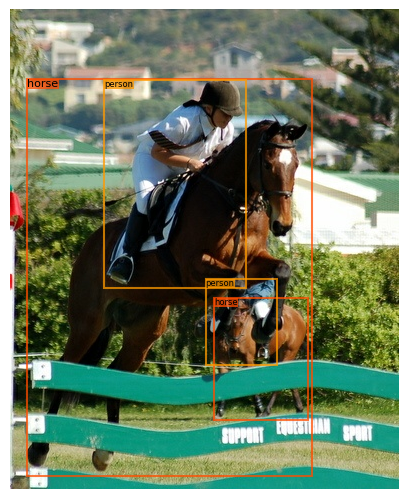

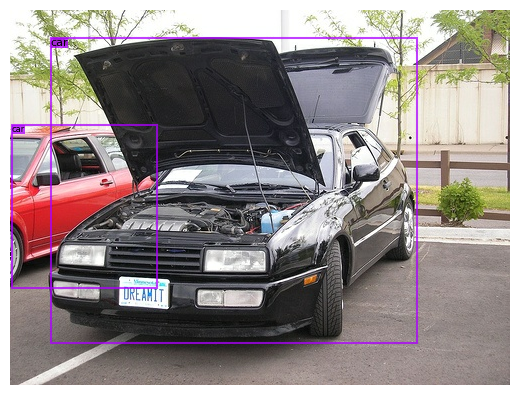

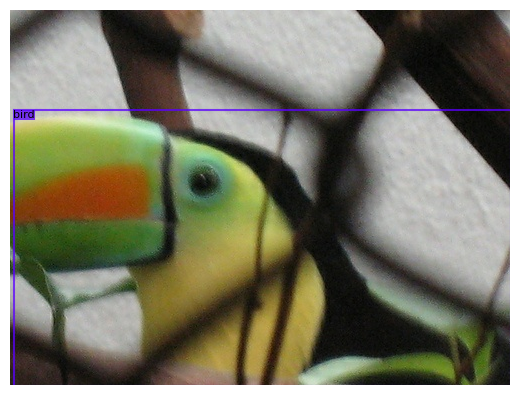

In [7]:
limits = 3

for i, example in enumerate(Train):
    if i >= limits:
        break

    # Extraction de l'image et de ses données
    image = example['image']
    labels = example['objects']['label']
    bboxes = example['objects']['bbox']
    height, width = image.shape[0:2]

    # Affichage avec l'outil (vis_bbox_fe | fe = for examples)
    vis_bbox_fe(image, labels, bboxes)

# **Data Augmentation**

In [6]:
import torch
import random
import torchvision.transforms.functional as F
from PIL import Image
from typing import Tuple, Union, Callable

class DataAugmentation:
    """Classe pour encapsuler des transformations d'images pour la Data Augmentation."""
    def __init__(self, transforms: List[Callable]):
        """
        Initialise la classe avec les transformations spécifiées.
        """
        self.transforms = transforms

    def __call__(self, image: np.ndarray, bboxes: torch.Tensor) -> Tuple[np.ndarray, List[List[float]]]:
        """
        Applique séquentiellement toutes les transformations sur l'image et ses cadres englobants.
        """
        image = Image.fromarray(image)
        for transform in self.transforms:
            image, bboxes = transform(image, bboxes)
        return np.array(image), bboxes

class HorizontalFlip:
    """Classe pour inverser horizontalement une image."""
    def __call__(self, image: Image.Image, bboxes: torch.Tensor) -> Tuple[Image.Image, List[List[float]]]:
        """
        Applique une transformation horizontale sur l'image et ses cadres englobants.
        """
        new_image = F.hflip(image)
        new_bboxes = bboxes.clone()
        new_bboxes[:, 1] = 1 - bboxes[:, 1] - (bboxes[:, 3] - bboxes[:, 1])
        new_bboxes[:, 3] = 1 - bboxes[:, 3] + (bboxes[:, 3] - bboxes[:, 1])
        return new_image, new_bboxes.tolist()

class VerticalFlip:
    """Classe pour inverser verticalement une image."""
    def __call__(self, image: Image.Image, bboxes: torch.Tensor) -> Tuple[Image.Image, List[List[float]]]:
        """
        Applique une transformation verticale sur l'image et ses cadres englobants.
        """
        new_image = F.vflip(image)
        new_bboxes = bboxes.clone()
        new_bboxes[:, 0] = 1 - bboxes[:, 0] - (bboxes[:, 2] - bboxes[:, 0])
        new_bboxes[:, 2] = 1 - bboxes[:, 2] + (bboxes[:, 2] - bboxes[:, 0])
        return new_image, new_bboxes.tolist()

class Brightness:
    """Classe pour ajuster la luminosité d'une image."""
    def __init__(self, brightness_factor: float):
        """
        Initialise la classe Brightness.
        """
        self.brightness = brightness_factor

    def __call__(self, image: Image.Image, bboxes: List[List[float]]) -> Tuple[Image.Image, List[List[float]]]:
        """
        Ajuste la luminosité d'une image.
        """
        new_image = F.adjust_brightness(image, self.brightness)
        return new_image, bboxes

class Contrast:
    """Classe pour ajuster le contraste d'une image."""
    def __init__(self, contrast_factor: float):
        """
        Initialise la classe Contrast.
        """
        self.contrast = contrast_factor

    def __call__(self, image: Image.Image, bboxes: List[List[float]]) -> Tuple[Image.Image, List[List[float]]]:
        """
        Ajuste le contraste d'une image.
        """
        new_image = F.adjust_contrast(image, self.contrast)
        return new_image, bboxes

class Saturation:
    """Classe pour ajuster la saturation d'une image."""
    def __init__(self, saturation_factor: float):
        """
        Initialise la classe Saturation.
        """
        self.saturation = saturation_factor

    def __call__(self, image: Image.Image, bboxes: List[List[float]]) -> Tuple[Image.Image, List[List[float]]]:
        """
        Ajuste la saturation d'une image.
        """
        new_image = F.adjust_saturation(image, self.saturation)
        return new_image, bboxes

class Lighting_noise:
    """Classe pour varier l'éclairage de manière aléatoire."""
    def __call__(self, image: Image.Image, bboxes: List[List[float]]) -> Tuple[Image.Image, List[List[float]]]:
        '''
        Varie l'éclairage de manière aléatoire.
        '''
        new_image = image
        perms = ((0, 1, 2), (0, 2, 1), (1, 0, 2),
                (1, 2, 0), (2, 0, 1), (2, 1, 0))
        swap = perms[random.randint(0, len(perms)- 1)]
        new_image = F.to_tensor(new_image)
        new_image = new_image[swap, :, :]
        new_image = F.to_pil_image(new_image)
        return new_image, bboxes

In [7]:
def DataAug(dataset: List[Dict], brightness_factor: float, saturation_factor: float, contrast_factor: float) -> List[Dict]:
    """
    Quadruple la taille de la base de données en effectuant de l'augmentation de données horizontales avec une modification légère de la luminosité.
    """
    # Transformations à appliquer
    TRANSFORMS = [(HorizontalFlip(), Brightness(brightness_factor)), (VerticalFlip(), Saturation(saturation_factor)), (Lighting_noise(), Contrast(contrast_factor))]
    N = len(dataset)

    for T in TRANSFORMS:
        transform = DataAugmentation(transforms=[t for t in T] if type(T) == tuple else [T])
        for i in range(N):
            # Extraction des données
            example = dataset[i]
            image = example['image']
            bboxes = example['objects']['bbox']
            labels = example['objects']['label']

            # Passage des cadres englobants en tenseurs
            bboxes = torch.tensor(bboxes)

            # Transformation
            transformed_image, transformed_bboxes = transform(image, bboxes)

            # Ajout au dataset
            dataset.append({'image': transformed_image, 'objects': {'bbox': transformed_bboxes, 'label': labels}})
    return dataset

# **Implémentation de notre Dataset**

La classe torch.utils.data.Dataset est utilisé pour former notre dataset (héritage), nous apportons un ajout correspondant à la conception/logique de notre modèle dans l'initialisation et dans le getitem. Il existe plusieurs format pour représenter les cadres englobants:
- Centrer (midpoint) (xc, yc, w, h): centre du parallélogramme, largeur et hauteur.
- Sommets (corners) (x1, y1, x2, y2): Sommets du parallélogramme.
- Origine (origin) (x, y, w, h): Sommet supérieur gauche, largeur et hauteur.

In [8]:
class Compose(object):
    """Classe pour encapsuler des transformations d'images."""
    def __init__(self, transforms: List[Callable]):
        """
        Initialise la classe Compose avec une liste de transformations.
        """
        self.transforms = transforms

    def __call__(self, image: Image.Image) -> Image.Image:
        """
        Applique séquentiellement les transformations à une image.
        """
        for t in self.transforms:
            image = t(image)
        return image

In [9]:
from typing import Optional
class YOLOV1Dataset(torch.utils.data.Dataset):
    """Classe Dataset pour YOLOV1"""
    def __init__(self, S: int, B: int, C: int, transform: Optional[Callable], dataset: List[Dict]):
        """
        Initialise la classe Dataset.

        Parameters:
            S: Nombre de cellules par hauteur et largeur.
            B: Nombre d'objets du même type par cellule.
            C: Nombre de classes dans la base de données.
        """
        self.S = S
        self.B = B
        self.C = C
        self.dataset = dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataset)

    def __subtreatment__(self, y: torch.Tensor, rate=5) -> int:
        """

        Parameters:
            y: Cellule (i,j).
            rate: Pas initialisé à 5 correspondant à un cadre de type (fiabilité, x, y, w, h).

        Returns:
            Retourne la position de la prédiction disponible de la cellule (i,j).

        """
        for i in range(self.C,y.shape[0],rate):
            if(y[i] == 0):
                return int(i/rate)
        return int((i/rate)) + 1

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Obtient un exemplaire de la base de données à partir de son indice et de sa représentation/labellisation tensorielle par le modèle.
        """
        # Extraction de l'image et de ses données
        example = self.dataset[index]
        image = example['image']
        image = Image.fromarray(image)
        bboxes = example['objects']['bbox']
        labels = example['objects']['label']


        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        if(self.transform):
            image = self.transform(image)

        for label, box in zip(labels, bboxes):
            y, x, y2, x2 = box
            w = x2 - x
            h = y2 - y

            # i,j représente la ligne et le colonne de la cellule
            i, j = int(self.S * y), int(self.S * x)

            # Normalisation selon le nouveau référenciel, l'origine de la cellule
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = (w * self.S, h * self.S)

            # Vérification de la non initialisation de classe pour la cellule
            pos = torch.nonzero(label_matrix[i, j, :self.C])
            if pos.nelement() != 0:
                # Vérification de l'homogénéité entre la classe de la cellule et celle de l'objet.
                if pos[0].item() == label:
                    n = self.__subtreatment__(label_matrix[i,j])
                    if n * 5 < self.B * 5 + self.C:
                        # Lors de la création du vecteur label_matrix la valeur confiance égale 1 signifie que l'objet est présent. Pour le modèle, il s'agit d'une probabilité entre 0 et 1, qui caractérise la fiabilité de sa prédiction.
                        label_matrix[i, j, n * 5] = 1

                        # Coordonnées des cadres englobants par rapport à la cellule (i,j)
                        box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                        label_matrix[i, j, n * 5 + 1:5 * (n+1)] = box_coordinates
            else:
                # Lors de la création du vecteur label_matrix la valeur confiance égale 1 signifie que l'objet est présent. Pour le modèle, il s'agit d'une probabilité entre 0 et 1, qui caractérise la fiabilité de sa prédiction.
                label_matrix[i, j, self.C] = 1

                # Coordonnées des cadres englobants par rapport à la cellule (i,j)
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                label_matrix[i, j, self.C+1:self.C+5] = box_coordinates

                # Initialisation de la classe de la cellule
                label_matrix[i, j, label] = 1

        return image, label_matrix

# **Métriques**

In [10]:
import seaborn as sns
from collections import Counter

def IoU(boxes_preds: torch.Tensor, boxes_targets: torch.Tensor) -> torch.Tensor:
    """
    Calcule l'intersection sur union. Métrique utilisée pour mesurer la concordance de deux parallélogramme dans un repère.

    Parameters :
        boxes_preds: Prédictions des cadres englobants. (BATCH_SIZE, 4)
        boxes_targets: Cadres englobants réelles. (BATCH_SIZE, 4)

    Returns :
        Intersection sur l'union pour tous les cadres englobants.
    """

    preds_x1 = boxes_preds[..., 0:1]
    preds_y1 = boxes_preds[..., 1:2]
    preds_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3]
    preds_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4]
    targets_x1 = boxes_targets[..., 0:1]
    targets_y1 = boxes_targets[..., 1:2]
    targets_x2 = boxes_targets[..., 0:1] + boxes_targets[..., 2:3]
    targets_y2 = boxes_targets[..., 1:2] + boxes_targets[..., 3:4]

    x1 = torch.max(preds_x1, targets_x1)
    y1 = torch.max(preds_y1, targets_y1)
    x2 = torch.min(preds_x2, targets_x2)
    y2 = torch.min(preds_y2, targets_y2)

    # .clamp(0) est utilisé dans le cas où il n'y a pas d'intersection et permet de fixer le minimum 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    preds_area = abs((preds_x2 - preds_x1) * (preds_y2 - preds_y1))
    targets_area = abs((targets_x2 - targets_x1) * (targets_y2 - targets_y1))

    # 1e-6 est utilisé dans le cas quasi-impossible où les deux rectangles possèdent une aire égale à 0
    return intersection / (preds_area + targets_area - intersection + 1e-6)

def metrics(pred_boxes: List[List], target_boxes: List[List], iou_threshold: float, num_classes: int) -> float:
    """
    Calcule, selon un seuil, la précision moyenne (mAP), le recall, la métrique precision et f1-score.

    Paramètres:
        pred_boxes: Liste de listes contenant toutes les cadres englobants avec chaque cadre englobant spécifié comme [train_idx, class_id, fiabilité, x, y, w, h].
        target_boxes: Similaire à pred_boxes sauf qu'il s'agit des véritables cadres englobants.
        iou_threshold: Seuil IoU (entre le cadre prédit et réel) considéré comme correcte.
        num_classes: Nombre de classes dans la base de données.

    Retourne :
        Les métriques en fonction d'un seuil.
    """
    mean_average_precision = []
    mean_recall = []
    mean_precision = []
    mean_f1_score = []

    # utilisé pour la stabilité numérique
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Trie en fonction de la classe
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for target_box in target_boxes:
            if target_box[1] == c:
                ground_truths.append(target_box)

        # Compte le nombre de cadre englobant par image
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Trie en fonction du score des valeurs de fiabilités
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # Si pour la classe c, nous avons rien, nous passons à la classe suivante
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Trie en fonction du de l'index du lot (batch)
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = IoU(torch.tensor(detection[3:]), torch.tensor(gt[3:]))

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # Si l'IoU est inférieur alors il est considéré comme un faux positif
            else:
                FP[detection_idx] = 1

        TP_cumsum = TP.cumsum(dim=0)
        FP_cumsum = FP.cumsum(dim=0)

        recall = TP.sum(dim=0) / (total_true_bboxes + epsilon)
        precision = TP.sum(dim=0) / (TP.sum(dim=0) + FP.sum(dim=0) + epsilon)

        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        mean_recall.append(recall)
        mean_precision.append(precision)
        mean_f1_score.append(2 * (recall * precision / (recall + precision + 1e-8)))

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        # torch.trapz permet d'intégrer
        mean_average_precision.append(torch.trapz(precisions, recalls))

    # Dans le cas où aucun objet est présent sur l'image
    if len(mean_average_precision) != 0:
        mean_average_precision = sum(mean_average_precision) / len(mean_average_precision)
        mean_recall = sum(mean_recall) / len(mean_recall)
        mean_precision = sum(mean_precision) / len(mean_precision)
        mean_f1_score = sum(mean_f1_score) / len(mean_f1_score)
    else:
        mean_average_precision = torch.tensor([0])
        mean_recall = torch.tensor([0])
        mean_precision = torch.tensor([0])
        mean_f1_score = torch.tensor([0])

    return mean_average_precision, mean_recall, mean_precision, mean_f1_score

def confusion_matrix(batch: int, pred_boxes: List[List], target_boxes: List[List], cm: np.ndarray, iou_threshold: float) -> float:
    """
    Réalise la matrice de confusion.

    Paramètres:
        batch: Nombre d'éléments par lot.
        pred_boxes: Liste de listes contenant toutes les cadres englobants avec chaque cadre englobant spécifié comme [train_idx, class_id, fiabilité, x, y, w, h].
        target_boxes: Similaire à pred_boxes sauf qu'il s'agit des véritables cadres englobants.
        cm: Matrice de confusion à mettre à jour.
        iou_threshold: Seuil IoU (entre le cadre prédit et réel) considéré comme correcte.

    Retourne :
        Matrice de confusion mis à jour.
    """
    for idx in range(batch):
        detections = [detection for detection in pred_boxes if detection[0] == idx]
        ground_truths = [target for target in target_boxes if target[0] == idx]

        # Compte le nombre de cadre englobant par image
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Trie en fonction du score des valeurs de fiabilités
        detections.sort(key=lambda x: x[2], reverse=True)
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection in detections:
            detect_class_id = int(detection[1])

            best_iou = 0
            gt_class_id = None

            for idx, gt in enumerate(ground_truths):
                iou = IoU(torch.tensor(detection[3:]), torch.tensor(gt[3:]))

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
                    gt_class_id = int(gt[1])

            if best_iou > iou_threshold and detect_class_id == gt_class_id:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                    cm[detect_class_id][detect_class_id] += 1

            # Si l'IoU est inférieur alors il est considéré comme un faux positif
            else:
                if gt_class_id is not None:
                    cm[detect_class_id][gt_class_id] += 1
    return cm

# **Outils**

NMS est une méthode utilisée pour la détection d'objets. Tous les modèles vu auparavant peuvent prédire en fonction de leurs caractéristiques des centaines de cadres englobants sur l'image. D'où l'intérêt d'utiliser cette méthode dont la principale fonction est de nettoyer l'image des cadres redondants et non pertinents:
1. Conserver les cadres englobants dont la valeur de fiabilité est supérieure ou égale à un seuil de confiance (valeur entre 0 et 1 de la qualité de la prédiction selon le modèle). Tri décroissant des cadres englobants selon leur valeur de fiabilité.
2. Sélectionner du cadre englobant prédit avec la meilleure fiabilité et le considérer comme le meilleur.
3. Parcourir le reste du tri, supprimer ceux dont la valeur IoU avec le "meilleur" cadre est égale ou supérieur à un seuil définit. Alternative, supprimer ceux dont la valeur IoU avec le "meilleur" cadre est égale ou supérieur à un seuil définit et avoir la même classe.
4. Conserver le meilleur cadre et répéter le processus jusqu'à que la liste de tri de prédictions soit vide.

In [11]:
def non_max_suppression(bboxes: List[torch.Tensor], iou_threshold: float, threshold: float, alternative: bool=False) -> List[torch.Tensor]:
    """
    Parameters :
        bboxes: Liste contenant toutes les cadres englobants (Tenseurs) de format [classe_prédite, prob (fiabilité de prédiction), x, y, w, h]
        iou_threshold: Seuil IoU entre deux cadres englobants considéré comme "proche" (voir explications).
        threshold: Seuil de la fiabilité de la prédiction considéré comme correcte.
        alternative: Ajoute à l'étape 3 du NMS une condition.

    Returns:
        Cadres englobants après NMS.
    """
    # Tri des prédictions : Tri décroissant des cadres englobants selon leur probabilité (fiabilité de la prédiction selon le modèle)
    bboxes = sorted([box for box in bboxes if box[1] > threshold], key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []
    while bboxes:
        # Sélection du meilleur cadre : Sélection du cadre englobant prédit avec le meilleur score et le considérer comme le meilleur
        best_box = bboxes.pop(0)

        # Suppression des cadres redondants : Parcourir le reste du tri. Supprimer ceux qui ont une IoU qui dépasse le seuil IoU avec le "meilleur" cadre. (ALTERNATIVE)
        if alternative:
            bboxes = [box for box in bboxes if IoU(best_box[2:], box[2:]) < iou_threshold or best_box[0] != box[0]]
        else:
            bboxes = [box for box in bboxes if IoU(best_box[2:], box[2:]) < iou_threshold]

        bboxes_after_nms.append(best_box)
    return bboxes_after_nms

In [12]:
def get_bboxes(batch: int, S: int, B: int, C: int, targets: torch.Tensor, predictions: torch.Tensor, iou_threshold: float, threshold: float) -> List[List]:
    """
    Méthode permettant de convertir les prédictions et les annotations réelles du point de vue cellule au point de vue image.

    Parameters:
        batch: Nombre d'images par lot.
        S: Nombre de cellules par hauteur et largeur.
        B: Nombre d'objets du même type par cellule.
        C: Nombre de classes dans la base de données.
        targets: Annotations réelles.
        predictions: Prédictions des annotations par le modèle.
        iou_thresold: Seuil IoU entre deux cadres englobants considéré comme "proche" (voir explications).
        threshold: Seuil de la fiabilité de la prédiction considéré comme correcte (utilisé par la méthode NMS).

    Returns:
        Toutes les prédictions et les annotations réelles du point de vue de l'image.
    """
    # Conversions des annotations et des prédictions
    target_bboxes = cellboxes_to_boxes(targets, S, B, C)
    pred_bboxes = cellboxes_to_boxes(predictions, S, B, C)

    all_preds = []
    all_targets = []
    for idx in range(batch):
        # Application du non-max-suppression
        nms_boxes = non_max_suppression(
            pred_bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
        )
        # listes des pred and true en fonction de leur image
        for nms_box in nms_boxes:
            all_preds.append([idx]+nms_box.tolist())

        for box in target_bboxes[idx]:
            if box[1] == 1:
                all_targets.append([idx]+box.tolist())
    return all_preds, all_targets

def cellboxes_to_boxes(bboxes: torch.Tensor, S: int, B: int, C: int) -> List[torch.Tensor]:
    """
    Convertit les cadres enblobants du point de vue cellule à globale (image).

    Parameters:
        bboxes: Tenseur contenant les cadres englobants à transformer.
        S: Nombre de cellules par hauteur et largeur.
        B: Nombre d'objets du même type par cellule.
        C: Nombre de classes dans la base de données.
    Returns:
        Liste des cadres englobants pour chaque exemple dans le lot.
    """
    # Changement de machines pour la variable bboxes afin de pouvoir réaliser les calculs. Dans notre cas, une variable sur un gpu et une autre sur un cpu ne peuvent réaliser d'opérations entre elles.
    bboxes = bboxes.to("cpu")
    batch_size = bboxes.shape[0]

    # Indices des cellules
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)

    boundingboxes = []
    # Passage du référenciel de la cellule à celle de l'image
    for i in range(C, C + 5 * B, 5):
        label = bboxes[..., :C].argmax(-1).unsqueeze(-1)
        score = bboxes[..., i].unsqueeze(-1)
        x = (1 / S) * (bboxes[..., i+1:i+2] + cell_indices)
        y = (1 / S) * (bboxes[..., i + 2:i + 3] + cell_indices.permute(0, 2, 1, 3))
        w = (1 / S) * bboxes[..., i + 3:i + 4]
        h = (1 / S) * bboxes[..., i + 4:i + 5]

        # Concaténation
        converted_bboxes = torch.cat((x, y, w, h), dim=-1)
        converted_bboxes = torch.cat((label, score, converted_bboxes), dim=-1)

        boundingboxes.append(converted_bboxes)

    boundingboxes = torch.cat(boundingboxes, dim=-1)

    # Applatissement
    boundingboxes = boundingboxes.flatten(1,2)

    all_bboxes = []
    for batch_idx in range(boundingboxes.shape[0]):
        boxes = []
        for i in range(S * S):
            for j in range(0, B * 6, 6):
                boxes.append((boundingboxes[batch_idx][i][j:j+6]))
        all_bboxes.append(boxes)
    return all_bboxes

# **Implémentation du modèle YOLOV1**

**Architecture**

In [13]:
# (Taille du filtre, neurones, stride, padding)
architecture = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),]

**Modèle**

In [14]:
import torch.nn as nn
from typing import Any

class CNNBlock(nn.Module):
    """Définis un bloc convolutif."""
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        """
        Initialise la classe YOLOV1.

        Parameters:
            in_channels: Nombre de canaux dans l'image d'entrée.
            **kwargs: Arguments supplémentaires pour la création des couches de la tête.
        """
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Réalise la propagation du tenseur x dans le bloc convolutif.

        Parameters:
            x : Tenseur d'entrée du bloc.

        Returns:
            Sortie du bloc.
        """
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class YOLOV1(nn.Module):
    """Définis le modèle YOLOV1. Modèle utilisable uniquement pour des images 448x448"""
    def __init__(self, in_channels=3, **kwargs):
        """
        Initialise la classe YOLOV1.

        Parameters:
            in_channels: Nombre de canaux dans l'image d'entrée.
            **kwargs: Arguments supplémentaires pour la création des couches de la tête.
        """
        super(YOLOV1, self).__init__()
        self.architecture = architecture
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.head = self._create_head(**kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Réalise la propagation du tenseur x dans le modèle.

        Parameters:
            x : Image, tenseur d'entrée du modèle.

        Returns:
            Sortie du modèle, tenseur de taille (BATCH, S, S, C + B * 5).
        """
        x = self.darknet(x)
        return self.head(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture: List[Any]) -> nn.Sequential:
        """
        Construit la partie convolutive (backbone) du modèle.

        Parameters:
            architecture : Architecture de la partie convolutive.

        Returns:
            Partie convolutive.
        """
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_head(self, S: int, B: int, C: int) -> nn.Sequential:
        """
        Crée la tête du modèle.

        Parameters:
            S: Nombre de cellules en hauteur et en largeur.
            B: Nombre de prédictions par cellule / Nombre d'objets du même type par cellule.
            C: Nombre de classes d'objets à prédire.

        Returns:
            Tête du modèle de type YOLOV1.
        """
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5)),
        )

# **Implémentation du modèle YOLO V1 modifié**

In [15]:
class Modified_YOLOV1(nn.Module):
    """Définis un modèle de type YOLOV1."""
    def __init__(self, backbone: nn.Module, **kwargs: Any):
        """
        Initialise la classe Modified_YOLOV1.

        Parameters:
            backbone: Partie convolutive du modèle.
            **kwargs: Arguments supplémentaires pour la création des couches de la tête.
        """
        super(Modified_YOLOV1, self).__init__()
        self.backbone = backbone
        self.head = self._create_head(**kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Réalise la propagation du tenseur x dans le modèle.

        Parameters:
            x : Image, tenseur d'entrée du modèle.

        Returns:
            Sortie du modèle, tenseur de taille (BATCH, S, S, C + B * 5).
        """
        # Propagation de notre image dans le modèle
        x = self.backbone(x)

        # Transformation du tenseur x multidimensionnel en un vecteur unidimensionnel, suivie de la propagation dans la tête du modèle
        return self.head(torch.flatten(x, start_dim=1))

    def _create_head(self, dim_output: int, S: int, B: int, C: int) -> nn.Sequential:
        """
        Crée la tête du modèle.

        Parameters:
            dim_output: Dimension de la sortie du backbone/Dimension de l'entrée de la tête.
            S: Nombre de cellules en hauteur et en largeur.
            B: Nombre de prédictions par cellule / Nombre d'objets du même type par cellule.
            C: Nombre de classes d'objets à prédire.

        Returns:
            Tête du modèle de type YOLOV1.
        """
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_output, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(256, S * S * (B * 5 + C)))

# **Fonction Coût/Perte**

In [16]:
import torch
import torch.nn as nn

class YOLOV1Loss(nn.Module):
    """Définit la fonction perte/coût d'un modèle de type YOLOV1."""

    def __init__(self, S: int, B: int, C: int):
        """
        Initialise la classe de type YOLOV1Loss.

        Parameters:
            S: Nombre de cellules par hauteur et largeur.
            B: Nombre d'objets du même type par cellule.
            C: Nombre de classes dans la base de données.
        """
        super(YOLOV1Loss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        # Facteur Coordonnées et aucun objet
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Calcul la perte (coût) d'un modèle de type YOLOV1.

        Parameters:
            predictions: Prédictions du modèle.
            targets: Cibles réelles.

        Returns:
            Perte totale.
        """
        # Extraction et redimensionnemment des cadres englobants
        predictions_boxes = predictions[..., self.C:].clone()
        predictions_boxes = predictions_boxes.reshape((predictions_boxes.shape[0:3]) + (self.B, 5))

        targets_boxes = targets[..., self.C:].clone()
        targets_boxes = targets_boxes.reshape((targets_boxes.shape[0:3]) + (self.B, 5))

        # Fonction indicatrice
        obj = targets_boxes[..., 0] == 1
        no_obj = targets_boxes[..., 0] != 1

        # Perte Cadres englobants
        predictions_boxes[..., 3:5] = torch.sign(predictions_boxes[..., 3:5]) * torch.sqrt(torch.abs(predictions_boxes[..., 3:5] + 1e-6))
        targets_boxes[..., 3:5] = torch.sign(targets_boxes[..., 3:5]) * torch.sqrt(torch.abs(targets_boxes[..., 3:5] + 1e-6))

        box_loss = self.mse(predictions_boxes[obj][..., 1:5], targets_boxes[obj][..., 1:5])

        # Perte Présence ou non d'un objet
        object_loss = self.mse(predictions_boxes[obj][..., 0], targets_boxes[obj][..., 0])
        no_object_loss = self.mse(predictions_boxes[no_obj][..., 0], targets_boxes[no_obj][..., 0])

        # Perte Classes
        predictions_class = predictions[..., :self.C].clone()
        targets_class = targets[..., :self.C].clone()

        obj = obj.any(dim=3)

        class_loss = self.mse(predictions_class[obj], targets_class[obj])

        # Perte Globale
        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )
        return loss

# **Train**

In [17]:
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_fn(train_loader: DataLoader, model: nn.Module, optimizer: optim, loss_fn: nn.Module, device: str, iou_nms: float, iou_mAP: float, objectiveness: float) -> List[float]:
    """
    Entraîne le modèle.

    Parameters:
        train_loader: Itérable des données de l'entraînement.
        model: Modèle à entraîner.
        optimizer: Optimiseur utilisé pour la mise à jour des poids du modèle.
        loss_fn: Fonction de perte utilisée pour calculer la perte du modèle.
        device: Appareil sur lequel les données et le modèle sont placés (par exemple, 'cuda' pour GPU ou 'cpu' pour CPU).
        iou_nms: Seuil IoU pour la méthode NMS.
        iou_mAP: Seuil IoU pour mAP.
        objectiveness: Seuil fiabilité pour la méthode NMS.

    Returns:
        Perte moyenne et la mAP moyenne obtenues lors de l'entraînement.
    """
    # Passage du modèle en mode entraînement (les calculs de gradients seront effectués, mais aussi les dropout, etc... sous ce mode)
    model.train()

    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    mean_mAP = []
    mean_recall = []
    mean_precision = []
    mean_f1_score = []

    for x, y in loop:
        # Remise à zeros des valeurs de gradients
        optimizer.zero_grad()

        # Mise en place de ces vecteurs sur le GPU
        x, y = x.to(device), y.to(device)

        # Prédiction du modèle et redimensionnement
        y_pred = model(x)
        y_pred = y_pred.reshape(y.shape)

        # Calcul de la perte
        loss = loss_fn(y_pred, y)
        mean_loss.append(loss.item())

        # Calcul du gradient
        loss.backward()

        # Mise à jour des poids du modèle
        optimizer.step()

        # Transformation des cadres englobants du point de vue cellule en point de vue globale (image)
        preds_boxes, targets_boxes = get_bboxes(x.shape[0], loss_fn.S, loss_fn.B, loss_fn.C, y, y_pred, iou_threshold=iou_nms, threshold=objectiveness)

        # Transformation des cadres englobants du point de vue cellule en point de vue globale (image)
        mAP, recall, precision, f1_score = metrics(preds_boxes, targets_boxes, iou_threshold=iou_mAP, num_classes=loss_fn.C)
        mean_mAP.append(mAP.item())
        mean_recall.append(recall.item())
        mean_precision.append(precision.item())
        mean_f1_score.append(f1_score.item())

        loop.set_postfix(loss=loss.item(), mAP=mAP.item(), recall=recall.item(), precision=precision.item(), f1_score=f1_score.item())

    # Moyenne
    mean_loss = sum(mean_loss) / len(mean_loss)
    mean_mAP = sum(mean_mAP) / len(mean_mAP)
    mean_recall = sum(mean_recall) / len(mean_recall)
    mean_precision = sum(mean_precision) / len(mean_precision)
    mean_f1_score = sum(mean_f1_score) / len(mean_f1_score)

    print(f"Train Loss: {mean_loss} | Train mAP = {mean_mAP} | Train Recall = {mean_recall} | Train Precision = {mean_precision} | Train F1-Score = {mean_f1_score}\n")
    return mean_loss, mean_mAP, mean_recall, mean_precision, mean_f1_score

# **Validation**

In [18]:
def validation_fn(validation_loader: DataLoader, model: nn.Module, loss_fn: nn.Module, device: str, iou_nms: float, iou_mAP: float, objectiveness: float, experiment) -> List[float]:
    """
    Évalue le modèle.

    Parameters:
        validation_loader: Itérable des données de la validation.
        model: Modèle à évaluer.
        loss_fn: Fonction de perte utilisée pour calculer la perte du modèle.
        device: Appareil sur lequel les données et le modèle sont placés (par exemple, 'cuda' pour GPU ou 'cpu' pour CPU).
        iou_nms: Seuil IoU pour la méthode NMS.
        iou_mAP: Seuil IoU pour mAP.
        objectiveness: Seuil fiabilité pour la méthode NMS.
        experiment: Expérience de suivi des paramètres et des résultats de la validation.

    Returns:
        Perte moyenne et la mAP moyenne obtenues lors de la validation.
    """
    # Passage du modèle en mode évaluation (désactive les calculs de gradients, les dropouts...)
    model.eval()

    loop = tqdm(validation_loader, leave=True)
    mean_loss = []
    mean_mAP = []
    mean_recall = []
    mean_precision = []
    mean_f1_score = []

    # Matrice de confusion
    cm = np.zeros((loss_fn.C, loss_fn.C))

    for x, y in loop:

        # Mise en place de ces vecteurs sur le GPU
        x, y = x.to(device), y.to(device)

        # Prédiction du modèle et redimensionnement
        y_pred = model(x)
        y_pred = y_pred.reshape(y.shape)

        # Calcul de la perte
        loss = loss_fn(y_pred, y)
        mean_loss.append(loss.item())

        # Transformation des cadres englobants du point de vue cellule en point de vue globale (image)
        preds_boxes, targets_boxes = get_bboxes(x.shape[0], loss_fn.S, loss_fn.B, loss_fn.C, y, y_pred, iou_threshold=iou_nms, threshold=objectiveness)

        # Transformation des cadres englobants du point de vue cellule en point de vue globale (image)
        mAP, recall, precision, f1_score = metrics(preds_boxes, targets_boxes, iou_threshold=iou_mAP, num_classes=loss_fn.C)
        mean_mAP.append(mAP.item())
        mean_recall.append(recall.item())
        mean_precision.append(precision.item())
        mean_f1_score.append(f1_score.item())

        # Matrice de Confusion
        cm = confusion_matrix(x.shape[0], preds_boxes, targets_boxes, cm, iou_mAP)

        loop.set_postfix(loss=loss.item(), mAP=mAP.item(), recall=recall.item(), precision=precision.item(), f1_score=f1_score.item())

        if WANDB:
            for i in range(0,x.shape[0],int(x.shape[0]/2)):
                # Convertis le tenseur en tableau numpy
                image = (x[i].permute(1, 2, 0).cpu().numpy()*255).astype(np.uint8)
                image_true = image.copy()
                image_pred = image.copy()

                # Application des labels, des cadres englobants et des fiabilités
                labels = []
                bboxes = []
                objs = []
                for box in preds_boxes:
                    if box != [] and box[0] == i:
                        labels.append(int(box[1]))
                        bboxes.append(box[3:])
                        objs.append(box[2])

                image_pred = vis_bbox(image_pred, labels, bboxes, objs)

                labels = []
                bboxes = []
                objs = []
                for box in targets_boxes:
                    if box != [] and box[0] == i:
                        labels.append(int(box[1]))
                        bboxes.append(box[3:])
                        objs.append(box[2])

                image_true = vis_bbox(image_true, labels, bboxes, objs)

                # Convertis l'image en tenseur pour WandB
                #image_true = torch.from_numpy(image_true).permute(2, 0, 1).float()
                #image_pred = torch.from_numpy(image_pred).permute(2, 0, 1).float()

                # Envoie les images dans WandB
                try:
                    experiment.log({'Validation images': {
                        'true': wandb.Image(image_true, caption='Vérité terrain'),
                        'pred': wandb.Image(image_pred, caption='Prédite'),
                    }})
                except:
                    pass
    
    if WANDB:
        fig, ax = plt.subplots(figsize=(14,14))

        sns.heatmap(cm, square=True, annot=True, cbar=True, xticklabels=class_names, yticklabels=class_names)

        ax.set_ylabel('Predicted')
        ax.set_xlabel('True')
        ax.set_title('Confusion Matrix')

        # Suppression du padding
        fig.tight_layout(pad=0)

        # Sauvegarde de la figure dans un numpy.ndarray
        fig.canvas.draw()
        conf_image = np.array(fig.canvas.renderer.buffer_rgba())
        fig.clf()
        plt.close(fig)

        del fig
        del ax
        # Envoie les images dans WandB
        try:
            experiment.log({'Validation Confusion Matrix': wandb.Image(conf_image)})
        except:
            pass

    # Moyenne
    mean_loss = sum(mean_loss) / len(mean_loss)
    mean_mAP = sum(mean_mAP) / len(mean_mAP)
    mean_recall = sum(mean_recall) / len(mean_recall)
    mean_precision = sum(mean_precision) / len(mean_precision)
    mean_f1_score = sum(mean_f1_score) / len(mean_f1_score)

    print(f"Validation Loss: {mean_loss} | Validation mAP = {mean_mAP} | Validation Recall = {mean_recall} | Validation Precision = {mean_precision} | Validation F1-Score = {mean_f1_score}\n")
    return mean_loss, mean_mAP, mean_recall, mean_precision, mean_f1_score

# **Apprentissage/Entraînement**

In [ ]:
import os
import wandb
import traceback
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import models
from functools import reduce

# Hyperparamètre wandb
PROJECT_NAME = "YOLOV1"

# Hyperparamètres Entraînement/Validation
LEARNING_RATE = 1e-3
MILESTONES = [2, 45, 105]
WEIGHT_DECAY = 5e-4
EPOCHS = 135
BATCH_SIZE = 32
SIZE = 224
DIR_CHECKPOINTS = './'

# Hyperparamètres Dataset/Dataloader
NUM_WORKERS = os.cpu_count()
PIN_MEMORY = True
SHUFFLE = True
DROP_LAST = True
DATA_AUGMENTATION = True
BRIGHTNESS_FACTOR = 1.75
SATURATION_FACTOR = 2.0
CONTRAST_FACTOR = 2.75

def train_model(model: nn.Module, S: int, B: int, C: int, device: str, iou_nms: float, iou_mAP: float, objectiveness: float, run_name: str):
    if WANDB:
        wandb.login()
        experiment = wandb.init(project=PROJECT_NAME, resume='allow', name=run_name)
        experiment.config.update(dict(Batch=BATCH_SIZE, size_image=SIZE))
    else:
        experiment = None

    # Nombre de paramètres du modèle
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Nombre total de paramètres entraînables: {total_params}')

    # Fonction Perte
    loss_fn = YOLOV1Loss(S, B, C)

    # Optimiseur
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Pas variant en fonction des epochs
    scheduler = MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

    # Transformateur: transforme les images et les vecteurs label_matrix en tenseur
    transform = Compose([transforms.Resize((SIZE, SIZE)), transforms.ToTensor(),])

    # Data Augmentation
    if DATA_AUGMENTATION:
        X_train = list(Train.as_numpy_iterator())
        X_validation = list(Validation.as_numpy_iterator())
        X_train = DataAug(dataset=X_train, brightness_factor=BRIGHTNESS_FACTOR, saturation_factor=SATURATION_FACTOR, contrast_factor=CONTRAST_FACTOR)
    else:
        X_train = list(Train.as_numpy_iterator())
        X_validation = list(Validation.as_numpy_iterator())

    # Creation des Datasets
    train_dataset = YOLOV1Dataset(S=S, B=B, C=C, transform=transform, dataset=X_train)
    val_dataset = YOLOV1Dataset(S=S, B=B, C=C, transform=transform, dataset=X_validation)

    # Train DataLoader
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=SHUFFLE,
        drop_last=DROP_LAST,
    )

    # Validation DataLoader
    validation_loader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=SHUFFLE,
        drop_last=DROP_LAST,
    )

    best_val_mAP = 0

    # Apprentissage
    for epoch in range(1,EPOCHS+1):
        print(f"Epoch {epoch}/{EPOCHS}:")
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
            print(f"Learning Rate: {current_lr}")
            break

        train_loss, train_mAP, train_recall, train_precision, train_f1_score = train_fn(train_loader, model, optimizer, loss_fn, device, iou_nms, iou_mAP, objectiveness)

        # Mise à jour du pas pour la descente de gradient
        scheduler.step()

        val_loss, val_mAP, val_recall, val_precision, val_f1_score = validation_fn(validation_loader, model, loss_fn, device, iou_nms, iou_mAP, objectiveness, experiment)

        if WANDB:
            # Envoie des données sur wandb
            experiment.log({
                'Train Loss': train_loss,
                'Validation Loss': val_loss,
                'Train mAP': train_mAP,
                'Validation mAP': val_mAP,
                'Train Recall': train_recall,
                'Validation Recall': val_recall,
                'Train Precision': train_precision,
                'Validation Precision': val_precision,
                'Train F1-Score': train_f1_score,
                'Validation F1-Score': val_f1_score,
                'epoch': epoch,
                'learning rate': current_lr
            })

            # Données sur les poids et gradients du modèles
            try:
                histograms = {}
                for tag, value in model.named_parameters():
                    tag = tag.replace('/', '.')
                    if not (torch.isinf(value) | torch.isnan(value)).any():
                        histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                    if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                        histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())
            except:
                pass

            # Envoie des données sur wandb
            try:
                experiment.log({**histograms})
            except:
                pass

        # Sauvegarde notre meilleur modèle durant l'entraînement
        if best_val_mAP < val_mAP and DIR_CHECKPOINTS is not None and epoch != 1:
            # Passage en mode train afin de récupérer l'ensemble du modèle (Dropout, Normalisation, ...)
            model.train()
            best_val_mAP = val_mAP
            state_dict = model.state_dict()
            checkpoint_path = DIR_CHECKPOINTS + 'checkpoint.pth'
            torch.save(state_dict, checkpoint_path)
            print(f'Checkpoint {epoch} sauvegardé !')

            if WANDB:
                experiment.save(checkpoint_path, base_path=DIR_CHECKPOINTS)
    if WANDB:
        wandb.finish()

if __name__ == '__main__':
    # Hyperparamètres Modèle
    S = 7
    B = 2
    C = num_classes
    MODIFIED_MODEL = True
    IoU_NMS = 0.2
    IoU_mAP = 0.5
    OBJECTIVENESS = 0.5

    if MODIFIED_MODEL:
        EfficientNetV2S = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.DEFAULT')

        # Connexion entre le corps et la tête (Récupération de la dimension de sortie du modèle EfficientNetV2B2S)
        x = torch.rand((1,3, SIZE, SIZE))
        output = EfficientNetV2S.features(x).shape[1:]
        output = reduce(lambda x, y: x * y, output)
        model = Modified_YOLOV1(backbone=EfficientNetV2S.features, dim_output=output, S=S, B=B, C=C)
        RUN_NAME = "M_YOLOV1" + " " + str((SIZE, SIZE))
    else:
        model = YOLOV1(S=S, B=B, C=C)
        RUN_NAME ="YOLOV1" + " " + str((SIZE, SIZE))

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    
    model.to(DEVICE)
    try:
        train_model(
            model=model,
            S=S,
            B=B,
            C=C,
            device=DEVICE,
            iou_nms=IoU_NMS,
            iou_mAP=IoU_mAP,
            objectiveness=OBJECTIVENESS,
            run_name=RUN_NAME)
    except:
      traceback.print_exc()
      torch.cuda.empty_cache()